In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid, WikipediaNetwork, WebKB
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

In [2]:
from utility import utils
from importlib import reload
reload(utils)

<module 'utility.utils' from '/home/reef557/pr/py_code/classification_gnn/utility/utils.py'>

# Model, train/val/test functions

Two convolutional layers, convolution described here: [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_size, hidden_size)
        # self.conv1 = LaplacianMessagePassing(num_features=input_size, dY=6, sub_nodes=10)
        self.conv2 = GCNConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [28]:
def train(model, optimizer, criterion, data, split_num=0):
    model.train()
    optimizer.zero_grad()

    # if dataset mask has multiple splits defined, use split 'split_num'
    mask = data.train_mask if data.train_mask.shape == data.y.shape else data.train_mask[: , split_num]

    out = model(data.x, data.edge_index) # get logits

    loss = criterion(out[mask], data.y[mask]) # compute loss

    loss.backward()
    optimizer.step()
    
    return loss

def get_val_loss(model, optimizer, criterion, data, split_num=0):
    model.eval()

    mask = data.val_mask if data.val_mask.shape == data.y.shape else data.val_mask[: , split_num]

    with torch.no_grad():
        out = model(data.x, data.edge_index)

        loss = criterion(out[mask], data.y[mask])

    return loss

def test(model, data, split_num=0):
    model.eval()

    mask = data.test_mask if data.test_mask.shape == data.y.shape else data.test_mask[: , split_num]

    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # pick class with highest probability
        test_correct = pred[mask] == data.y[mask]
        test_acc = int(test_correct.sum()) / int(mask.sum())  # compute accuracy
    return test_acc

# Read/download data

In [74]:
# dataset = Planetoid(root='data/Planetoid', name='Cora') # uncomment needed dataset
# dataset = Planetoid(root='data/Planetoid', name='Pubmed')
# dataset = Planetoid(root='data/Planetoid', name='Citeseer')
# dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='Squirrel')
dataset = WebKB(root='data/WebKB', name='Wisconsin')
data = dataset[0]

# The default features

In [61]:
model = GCN(input_size=dataset.num_features, 
            hidden_size=16, 
            output_size=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 1

train_loss_history = []
val_loss_history = []

for epoch in range(1, 10):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

GCN(
  (conv1): GCNConv(1703, 16)
  (conv2): GCNConv(16, 5)
)
Epoch: 001, Loss: 1.7306
Epoch: 002, Loss: 1.3255
Epoch: 003, Loss: 1.2146
Epoch: 004, Loss: 1.1949
Epoch: 005, Loss: 1.0372
Epoch: 006, Loss: 1.1219
Epoch: 007, Loss: 1.2147
Epoch: 008, Loss: 0.9966
Epoch: 009, Loss: 1.2378


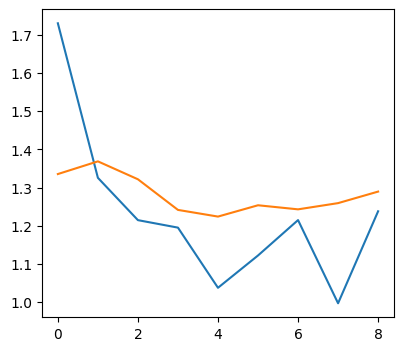

In [62]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [63]:
test_acc = test(model, data)

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.45098039215686275


# Laplacian-based positional encodings

In [90]:
eigenmap = utils.get_eigenmap_from_edge_index(data.edge_index, data.x.shape[0], d=8)

In [91]:
data.x = np.concat([data.x, eigenmap], axis=1)
data.x = torch.tensor(data.x, dtype=torch.float32)

In [92]:
model = GCN(input_size=data.x.shape[1], 
            hidden_size=16, 
            output_size=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 101):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

GCN(
  (conv1): GCNConv(1711, 16)
  (conv2): GCNConv(16, 5)
)
Epoch: 025, Loss: 0.7779
Epoch: 050, Loss: 0.5316
Epoch: 075, Loss: 0.4887
Epoch: 100, Loss: 0.3732


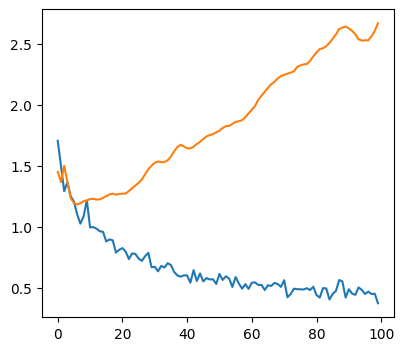

In [93]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [94]:
test_acc = test(model, data)

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.39215686274509803


# Sheaf based positional encodings

In [103]:
stalk_dim = 3
conn_laplacian = utils.local_pca_alignment(np.array(data.x), data.edge_index, stalk_dim)
conn_laplacian = torch.tensor(conn_laplacian, dtype=torch.float32)

/tmp/ipykernel_762/2584689557.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  conn_laplacian = utils.local_pca_alignment(np.array(data.x), data.edge_index, stalk_dim)
100%|██████████| 515/515 [00:26<00:00, 19.26it/s]


In [11]:
X = torch.arange(24).reshape(6,4)
mask = [3,2]
X[mask]

tensor([[12, 13, 14, 15],
        [ 8,  9, 10, 11]])

In [14]:
X = np.arange(24).reshape(6,4)
mask = [3,2]
X[mask] - X[0]

array([[12, 12, 12, 12],
       [ 8,  8,  8,  8]])

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing


class SheafDiffusion(nn.Module):
    def __init__(self, input_dim, hidden_channels, d, out_dim, graph_sz, conn_lap, num_layers=2):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_channels = hidden_channels
        self.hidden_dim = hidden_channels * d
        self.out_dim = out_dim
        self.graph_sz = graph_sz
        self.d = d # stalk dim

        self.num_layers = num_layers

        self.conn_lap = conn_lap

        self.left_w = nn.ModuleList()
        self.right_w = nn.ModuleList()
        self.eps = nn.ParameterList()
        for i in range(self.num_layers):
            self.right_w.append(nn.Linear(self.hidden_channels, self.hidden_channels, bias=False))
            nn.init.orthogonal_(self.right_w[-1].weight.data)

            self.left_w.append(nn.Linear(self.d, self.d, bias=False))
            nn.init.eye_(self.left_w[-1].weight.data)

            self.eps.append(nn.Parameter(torch.zeros((self.d, 1))))


        self.lin1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.lin2 = nn.Linear(self.hidden_dim, self.out_dim)
    
    def forward(self, x, edge_index):
        # print(f"x shape = {x.shape}")
        x = self.lin1(x)
        # print(f"x' shape = {x.shape}")
        x = x.view(self.graph_sz * self.d, -1)

        x0 = x
        for layer in range(self.num_layers):
            x = x.t().reshape(-1, self.d)
            x = self.left_w[layer](x)
            x = x.reshape(-1, self.graph_sz * self.d).t()

            x = self.right_w[layer](x)

            x = self.conn_lap @ x
            x0 = (1 + torch.tanh(self.eps[layer]).tile(self.graph_sz, 1)) * x0 - x
            x = x0

        x = x.reshape(self.graph_sz, -1)
        x = self.lin2(x)

        return x

In [100]:
conn_laplacian.sum()

tensor(424.4371)

In [96]:
np.prod(1)

np.int64(1)

In [82]:
emb_dim = 8
eigenmap = utils.get_eigenmap(conn_laplacian, emb_dim)

In [83]:
eigenmap.shape

torch.Size([753, 8])

In [84]:
data.x.shape

torch.Size([251, 1703])

In [85]:
eigenmaps = eigenmap.reshape((251, -1))

In [86]:
tmp = np.copy(data.x)

In [87]:
data.x = np.concat([tmp, eigenmaps], axis=1)

In [88]:
data.x = torch.tensor(data.x, dtype=torch.float32)

In [105]:
model = SheafDiffusion(input_dim=data.x.size(1), 
            hidden_channels=32,
            d=3, 
            out_dim=dataset.num_classes,
            graph_sz=data.x.size(0),
            conn_lap=conn_laplacian,
            num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 125):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

SheafDiffusion(
  (left_w): ModuleList(
    (0-1): 2 x Linear(in_features=3, out_features=3, bias=False)
  )
  (right_w): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=32, bias=False)
  )
  (eps): ParameterList(
      (0): Parameter containing: [torch.float32 of size 3x1]
      (1): Parameter containing: [torch.float32 of size 3x1]
  )
  (lin1): Linear(in_features=1703, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=5, bias=True)
)
Epoch: 025, Loss: 0.0058
Epoch: 050, Loss: 0.0003
Epoch: 075, Loss: 0.0002
Epoch: 100, Loss: 0.0003


In [111]:
model = GCN(input_size=data.x.shape[-1], 
            hidden_size=16, 
            output_size=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


print(model)

print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 200):
    
    loss = train(model, optimizer, criterion, data)
    train_loss_history.append(loss.item())

    val_loss = get_val_loss(model, optimizer, criterion, data)
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

GCN(
  (conv1): GCNConv(1735, 16)
  (conv2): GCNConv(16, 5)
)
Epoch: 025, Loss: 0.8232
Epoch: 050, Loss: 0.7215
Epoch: 075, Loss: 0.5896
Epoch: 100, Loss: 0.5105
Epoch: 125, Loss: 0.4756
Epoch: 150, Loss: 0.4978
Epoch: 175, Loss: 0.4981


In [106]:
test_acc = test(model, data)

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.6078431372549019


In [21]:
torch.arange(1,11).reshape((2,-1)).sum(dim=0)

tensor([ 7,  9, 11, 13, 15])

In [29]:
eigenfuncs = torch.tensor([[-0.5000],
        [-0.7071],
        [-0.5000]])
c = torch.tensor([[0.],
        [0.],
        [0.]])
x = torch.tensor([[-0.4114, -0.5071,  0.6963],
        [-1.7717,  0.7370,  0.1269],
        [-0.2905,  0.5852,  0.0144]])
dx = 3
dy= 1
c = []
print(x.shape)
for i in range(x.size(1)):
    for alpha in range(dy):
        print(f"{x[:, i]*eigenfuncs[:, alpha]/3}")
# for i in range(dx):
#     for alpha in range(dy):


torch.Size([3, 3])
tensor([0.0686, 0.4176, 0.0484])
tensor([ 0.0845, -0.1737, -0.0975])
tensor([-0.1161, -0.0299, -0.0024])


In [ ]:
eigen = torch.tensor([[-0.7071],
        [-0.5000],
        [-0.5000]])
c = torch.tensor([[-0.0314],
        [-0.5727],
        [-0.1295]])
x_rec = torch.tensor([0., 0., 0.])